In [2]:
import os

import albumentations as album
import cv2

import numpy as np

import pandas as pd
from PIL import Image

import segmentation_models_pytorch as smp
import torch

/home/asrulsibaoel/miniconda3/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "data/raw/deepglobe-road-extraction-dataset"

In [4]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None) -> album.Compose:
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

In [5]:
# load best saved model checkpoint from the current run
if os.path.exists('./models/deeplab-road-model.pth'):
    best_model = torch.load('./models/deeplab-road-model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

/tmp/ipykernel_634/2252813359.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('./models/deeplab-road-model.pth', map_location=DEVICE)


Loaded DeepLabV3+ model from this run.


In [6]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [7]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [8]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [9]:
def load_image(img_path: str) -> np.ndarray:
    # read images and masks
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    height, width = image.shape[:2]
    
    # Calculate padding to make height and width divisible by 16
    pad_height = (16 - height % 16) % 16  # Height padding
    pad_width = (16 - width % 16) % 16    # Width padding
    
    image = cv2.copyMakeBorder(
        image, 
        0, pad_height, 
        0, pad_width, 
        borderType=cv2.BORDER_CONSTANT, 
        value=[0, 0, 0]  # Fill with black (0, 0, 0) for color images (BGR)
    )
    # apply preprocessing
    preprocessing  = get_preprocessing(preprocessing_fn)
    sample = preprocessing(image=image)
    image= sample['image']
        
    return image

In [10]:
def predict(test_image_path: str) -> np.ndarray:
    image = load_image(test_image_path)
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))

    # Step 1: Extract probabilities for the 'road' class
    road_probabilities = pred_mask[:, :, 1]  # Assuming 1st index corresponds to 'road'

    # Step 3: Normalize probabilities to 0-255 for visualization
    image_data = (road_probabilities * 255).astype(np.uint8)

    return image_data

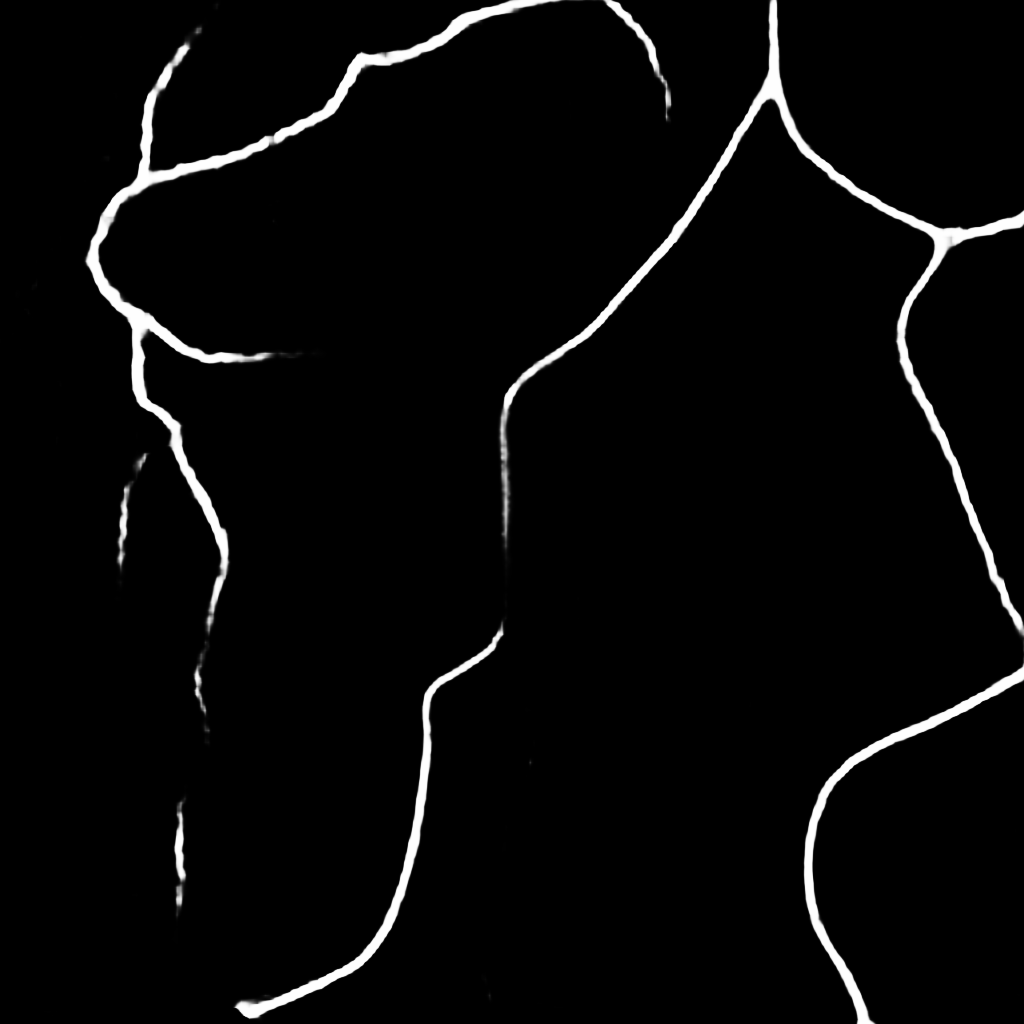

In [13]:
test_image_path = "data/raw/deepglobe-road-extraction-dataset/test/982758_sat.jpg"
np_result = predict(test_image_path)

Image.fromarray(np_result)